# Setup

## Data Import

In [1]:
from itertools import combinations, permutations
from pathlib import Path

import numpy as np
import pandas as pd
from sqlite3 import connect

from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(707260)

In [2]:
con = connect('../results.db')
tables = pd.read_sql(
    "SELECT * FROM sqlite_master", 
    con=con
).loc[:, 'name']
con.close()

In [3]:
df_map = {}

bad_vals = 0

# df_idx = ['dataset', 'model', 'weight', 'ori', 'prep']
analysis_idx = ['dataset', 'model', 'weight', 'ori', 'prep']

con = connect('../results.db')
for t in tables:
    # Pull the dataframe from the database
    try:
        df = pd.read_sql(
            f"SELECT * FROM {t}", 
            con=con
        )
    except:
        print(f"Failed to read table {t}, ignoring it")
        bad_vals += 1
        continue

    # If the table represents a study which wasn't run to completion, end early and report it
    if df.shape[0] < 1000:
        # print(f"Study {t} was not completed")
        bad_vals += 1
        continue

    # Split the DataFrame's label into its components
    label_comps = t.split('__')

    # Pull the model label from it
    model = label_comps[1]

    # The rest of the components are in the final tag
    final_comps = label_comps[-1].split('_')
    if final_comps[0] == 'full':
        dataset = "full"
        ori = final_comps[1]
        weight = final_comps[2]
        prep = '_'.join(final_comps[3:])
        df_key = "_".join([dataset, model, ori, weight, prep])
    elif final_comps[0] == 'img':
        dataset = 'img'
        ori = final_comps[2]
        weight = final_comps[3]
        prep = '_'.join(final_comps[4:])
        df_key = "_".join([dataset, model, ori, weight, prep])
    elif final_comps[0] == 'clinical':
        dataset = 'clinical'
        ori = 'none'
        weight = 'none'
        prep = '_'.join(final_comps[2:])
        df_key = "_".join([dataset, model, ori, weight, prep])
    
    # Store the components in the dataframe itself
    df['dataset'] = dataset
    df['model'] = model
    df['weight'] = weight
    df['ori'] = ori
    df['prep'] = prep
    
    # Track the resulting dataframe via the result
    df_map[df_key] = df

con.close()

print(f"\nTotal No. bad values: {bad_vals}")


Total No. bad values: 20


In [4]:
len(df_map)

155

## Performance Metric Stacking

All metrics in the below index list are tracked for all analyses, so are safe to query (and stack) from all analytical permutations

In [5]:
shared_performance_metric_idxs = [
    "objective",
    "balanced_accuracy (validate)",
    "roc_auc (validate)",
    "log_loss (validate)",
    "balanced_accuracy (test)",
    "roc_auc (test)",
    "log_loss (test)",
    "importance_by_permutation (test)"
    
]

In [6]:
study_idxs = [
    "replicate",
    "trial"
]

In [7]:
def stack_performance_metrics():
    sub_dfs = []
    for df in df_map.values():
        sub_df = df.loc[:, [*analysis_idx, *study_idxs, *shared_performance_metric_idxs]]
        sub_dfs.append(sub_df)
    return pd.concat(sub_dfs)

performance_metric_df = stack_performance_metrics()

# Patient Metric Distributions

## Data Importing

In [8]:
clinical_metric_df = pd.read_csv("../softseg_data/clinical_only.tsv", sep='\t')
clinical_metric_df

GRP  EQ5D: Anxiety/Depression  EQ5D: Mobility  \
0    sub-cMRI10248                       2.0             1.0   
1    sub-cMRI10361                       1.0             2.0   
2    sub-cMRI10473                       2.0             1.0   
3    sub-cMRI10475                       1.0             2.0   
4    sub-cMRI10489                       2.0             2.0   
..             ...                       ...             ...   
287   sub-cMRI9790                       2.0             1.0   
288   sub-cMRI9809                       3.0             2.0   
289   sub-cMRI9884                       1.0             2.0   
290   sub-cMRI9907                       1.0             1.0   
291   sub-cMRI9909                       2.0             2.0   

     EQ5D: Pain/Discomfort  EQ5D: Self-Care  EQ5D: Total  \
0                      2.0              1.0     0.767599   
1                      2.0              1.0     0.777806   
2                      2.0              1.0     0.767599   
3                      3.0              1.0     0.445656   
4                      2.0              2.0     0.597189   
..                     ...              ...          ...   
287                    2.0              1.0     0.767599   
288                    3.0              2.0     0.203610   
289                    2.0              1.0     0.810001   
290                    2.0              2.0     0.748480   
291                    2.0              2.0     0.597189   

     EQ5D: Usual Activities        MCS   NDI        PCS  ...  \
0                       2.0        NaN  53.0        NaN  ...   
1                       2.0  60.273705   4.0  49.269280  ...   
2                       2.0  29.835336  36.0  32.346289  ...   
3                       2.0  50.130626  42.0  21.659021  ...   
4                       2.0  35.648014  33.0  29.809632  ...   
..                      ...        ...   ...        ...  ...   
287                     2.0  39.683649  38.0  41.151715  ...   
288                     2.0  23.683175  54.0  31.216432  ...   
289                     1.0  58.498663  20.0  44.671210  ...   
290                     2.0  41.885403  22.0  41.920181  ...   
291                     2.0  48.333471  54.0  26.322544  ...   

                  Work Status  Work Status (Category)  \
0    Employed but not working                      NW   
1          *Currently working                       W   
2          *Currently working                       W   
3                     Retiree                     HSR   
4                     Retiree                     HSR   
..                        ...                     ...   
287              Not employed                      NW   
288  Employed but not working                      NW   
289                     Other                     HSR   
290        *Currently working                       W   
291              Not employed                      NW   

     Comorbidities: Nicotine (Smoking)  Comorbidities: Nicotine (Smokeless)  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  1.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   
..                                 ...                                  ...   
287                                1.0                                  0.0   
288                                0.0                                  0.0   
289                                0.0                                  0.0   
290                                0.0                                  0.0   
291                                1.0                                  0.0   

     Comorbidities: Nicotine (Patches)  Comorbidities: Nicotine (Recent Quit)  \
0                                  0.0   

## mJOA

Setup

In [9]:
def plot_distributions(data, cmap, legend_elements, xlabel, title, mean_offset=0, flip_mean_rot=False):
    # Get the appropriate ranges for the data
    min_range = int(np.min(data))-1
    max_range = int(np.max(data))+1
    
    # Bin the data
    hist, bins = np.histogram(
        data, 
        np.array(range(min_range, max_range))+.1
    )
    
    # Generate the figure
    fig, ax = plt.subplots()
        
    # Iteratively color code the bars
    for t, c in cmap.items():
        mask = bins < t
        to_display = np.array(range(min_range, t))+0.5
        vals = hist[mask[:-1]]
        ax.bar(
            to_display, vals,
            width=1, color=c,
            align='edge',
            edgecolor='black'
        )
        
    # Add a mean line
    data_mean = np.mean(data)
    ax.axvline(data_mean, ls='--', c='black')
    if flip_mean_rot:
        ax.text(data_mean-0.5, ax.get_ylim()[1]-mean_offset, f"Mean ({data_mean:.4})", rotation=90)
    else:
        ax.text(data_mean+0.05, ax.get_ylim()[1]-mean_offset, f"Mean ({data_mean:.4})", rotation=-90)
        
    # Add in the legend
    ax.legend(handles=legend_elements)
    
    # Add in labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(title)
    
    # Return the figure and axis
    return fig, ax

In [10]:
# Limits so that all plots have consistent range
xlim_min = int(np.min([*clinical_metric_df['mJOA initial'], *clinical_metric_df['mJOA 12 months']]))-1
xlim_max = int(np.max([*clinical_metric_df['mJOA initial'], *clinical_metric_df['mJOA 12 months']]))+1

ylim_min = 0
ylim_max = int(np.max([
    *np.histogram(clinical_metric_df['mJOA initial'], np.array(range(xlim_min, xlim_max))+.1)[0],
    *np.histogram(clinical_metric_df['mJOA 12 months'], np.array(range(xlim_min, xlim_max))+.1)[0]
]))+5

# Color threshold map
severity_cmap = {
    18: 'blue',
    17: 'green',
    14: 'gold',
    11: 'red'
}

# Generate a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Severe'),
    Patch(facecolor='gold', edgecolor='black', label='Moderate'),
    Patch(facecolor='green', edgecolor='black', label='Mild'),
    Patch(facecolor='blue', edgecolor='black', label='Healthy'),
]

# DCM Severity labelling
clinical_metric_df['DCM Severity initial'] = 'Severe'
clinical_metric_df.loc[clinical_metric_df['mJOA initial'] > 11, 'DCM Severity initial'] = 'Moderate'
clinical_metric_df.loc[clinical_metric_df['mJOA initial'] > 14, 'DCM Severity initial'] = 'Mild'
clinical_metric_df.loc[clinical_metric_df['mJOA initial'] > 17, 'DCM Severity initial'] = 'Healthy'

clinical_metric_df['DCM Severity 12 months'] = 'Severe'
clinical_metric_df.loc[clinical_metric_df['mJOA 12 months'] > 11, 'DCM Severity 12 months'] = 'Moderate'
clinical_metric_df.loc[clinical_metric_df['mJOA 12 months'] > 14, 'DCM Severity 12 months'] = 'Mild'
clinical_metric_df.loc[clinical_metric_df['mJOA 12 months'] > 17, 'DCM Severity 12 months'] = 'Healthy'

# Output path for the files
mjoa_dist_out_path = Path('figures/mjoa_dist')
if not mjoa_dist_out_path.exists():
    mjoa_dist_out_path.mkdir(parents=True)

### Initial

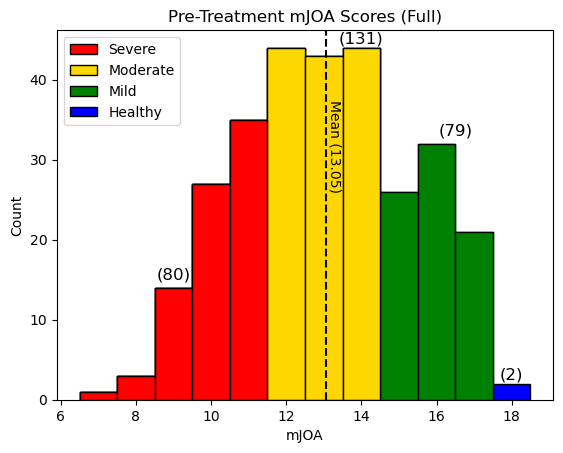

In [11]:
# Plot the data
fig, ax = plot_distributions(
    clinical_metric_df['mJOA initial'], severity_cmap, legend_elements,
    'mJOA', 'Pre-Treatment mJOA Scores (Full)', 20
)

# Plot the total number of each severity class as text
severity_counts = clinical_metric_df['DCM Severity initial'].value_counts()
ax.text(9, 15, f"({severity_counts['Severe']})", c='black', size=12, horizontalalignment='center')
ax.text(14, 44.5, f"({severity_counts['Moderate']})", c='black', size=12, horizontalalignment='center')
ax.text(16.5, 33, f"({severity_counts['Mild']})", c='black', size=12, horizontalalignment='center')
ax.text(18, 2.5, f"({severity_counts['Healthy']})", c='black', size=12, horizontalalignment='center')

# Save and show the result
fig.savefig(mjoa_dist_out_path / 'pre_treatment_mjoa.svg')
plt.show()

### 12 Month

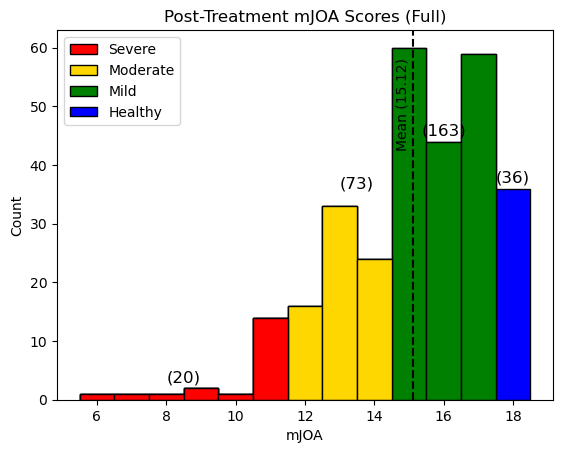

In [12]:
# Plot the data
fig, ax = plot_distributions(
    clinical_metric_df['mJOA 12 months'], severity_cmap, legend_elements,
    'mJOA', 'Post-Treatment mJOA Scores (Full)', 20, flip_mean_rot=True
)

# Plot the total number of each severity class as text
severity_counts = clinical_metric_df['DCM Severity 12 months'].value_counts()
ax.text(8.5, 3, f"({severity_counts['Severe']})", c='black', size=12, horizontalalignment='center')
ax.text(13.5, 36, f"({severity_counts['Moderate']})", c='black', size=12, horizontalalignment='center')
ax.text(16, 45, f"({severity_counts['Mild']})", c='black', size=12, horizontalalignment='center')
ax.text(18, 37, f"({severity_counts['Healthy']})", c='black', size=12, horizontalalignment='center')

# Save and show the result
fig.savefig(mjoa_dist_out_path / 'post_treatment_mjoa.svg')
plt.show()

### mJOA Delta

In [13]:
# Define a new color scheme and legend for this new style of data
delta_cmap = {
    8: 'springgreen',
    0: 'white',
    -1: 'salmon'
}

delta_legend_elements = [
    Patch(facecolor='springgreen', edgecolor='black', label='Improved'),
    Patch(facecolor='white', edgecolor='black', label='No Change'),
    Patch(facecolor='salmon', edgecolor='black', label='Declined'),
]

xticks = (
    list(range(-8, 9, 2)),
    list(range(-8, 9, 2))
)

deltas = clinical_metric_df['mJOA 12 months'] - clinical_metric_df['mJOA initial']

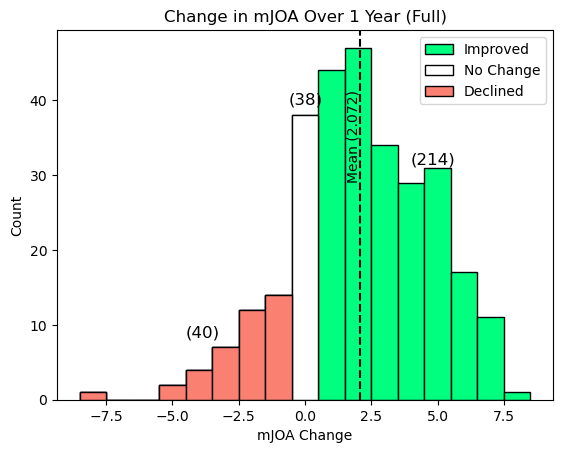

In [14]:
# Plot the deltas
fig, ax = plot_distributions(
    deltas, delta_cmap, delta_legend_elements, 
    "mJOA Change", 'Change in mJOA Over 1 Year (Full)', 20, flip_mean_rot=True
)

# Plot the total number of each severity class as text
change_counts = pd.cut(
    deltas, 
    [-20, -1, 0, 20], 
    labels=['Declined', 'No Change', 'Improved']
).value_counts()
ax.text(-4.5, 9, f"({change_counts['Declined']})", c='black', size=12, verticalalignment='center')
ax.text(-0.6, 40, f"({change_counts['No Change']})", c='black', size=12, verticalalignment='center')
ax.text(4, 32, f"({change_counts['Improved']})", c='black', size=12, verticalalignment='center')

# Save and show the result
fig.savefig(mjoa_dist_out_path / 'treatment_mjoa_delta.svg')
plt.show()

## Hirayabashi Recovery Ratio Distribution

Setup

In [15]:
from scipy.stats import gaussian_kde

# Plot the KDE distribution onto an existing plot
def plot_kde(ax, values, c='black', ls='-', label=None):
    kde = gaussian_kde(values)
    kde.covariance_factor = lambda: 0.15
    kde._compute_covariance()
    xs = np.linspace(np.min(values), np.max(values), 200)
    ys = kde(xs)
    ys /= np.linalg.norm(ys)
    if label == None:
        ax.plot(xs, ys, ls=ls, c=c)
    else:
        ax.plot(xs, ys, ls=ls, c=c, label=label)

# Clean out invalid values from the set
def clean_vals(df):
    df2 = df[df != -np.inf]
    df2 = df2.dropna()
    return df2

# Adds important reference lines to the plot
def draw_line_references(ax):
    # Significant improvement
    ax.axvline(0.5, ls='-.', c='grey')
    
    # Baselines
    ax.axhline(0, ls=":",  c='lightgrey') 
    ax.axvline(0, ls=":",  c='lightgrey')

# The HRR Equation, for immediate reference within the plot
hirabayashi_equation = r"HRR = $\frac{\mathrm{mJOA (1 Year)} - \mathrm{mJOA (Initial)}}{18 - \mathrm{mJOA (Initial)}}$"

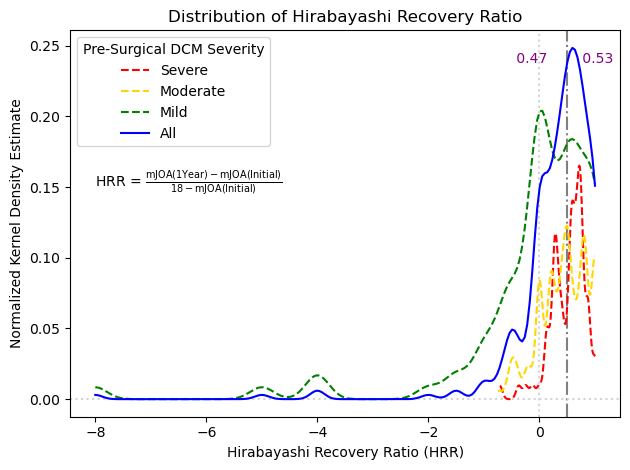

In [16]:
# Get the HRR for our patients, skipping over initially healthy patients who could not improve whatsoever
hrr_df = clinical_metric_df.loc[clinical_metric_df['DCM Severity initial'] != "Healthy", 'HRR']

# Generate the initial plot
fig, ax = plt.subplots()

# Plot our reference lines
draw_line_references(ax)

# Plot the distributions by their initial severity class
plot_kde(
    ax, clean_vals(hrr_df[clinical_metric_df['DCM Severity initial'] == 'Severe']), ls='--', c='red', label='Severe'
)
plot_kde(
    ax, clean_vals(hrr_df[clinical_metric_df['DCM Severity initial'] == 'Moderate']), ls='--', c='gold', label='Moderate'
)
plot_kde(
    ax, clean_vals(hrr_df[clinical_metric_df['DCM Severity initial'] == 'Mild']), ls='--', c='green', label='Mild'
)

# Plot the overall distribution
plot_kde(ax, hrr_df, c='blue', label='All')

# Calculate the ratio above and below the HRR significance threshold, and add it
good_ratio = np.sum(hrr_df >= 0.5)/hrr_df.shape[0]
fair_ratio = np.sum(hrr_df < 0.5)/hrr_df.shape[0]

ax.text(0.7, 0.238, f"{good_ratio: .2f}", c='purple')
ax.text(-0.5, 0.238, f"{fair_ratio: .2f}", c='purple')

# Add axis labels
ax.set_xlabel('Hirabayashi Recovery Ratio (HRR)')
ax.set_ylabel('Normalized Kernel Density Estimate')

# Add a legend
ax.legend(title='Pre-Surgical DCM Severity')

# Add hirabayashi equation directly to plot
ax.text(-8, 0.15, hirabayashi_equation)

# Add a title
ax.set_title("Distribution of Hirabayashi Recovery Ratio")

plt.tight_layout()

fig.savefig(mjoa_dist_out_path / 'hirabayashi_ratios.svg')

plt.show()

## Demographics

In [17]:
def plot_continuous_demographics(col):
    sns.displot(clinical_metric_df, x=col)
    plt.title(f"Patient Distribution ({col})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"figures/demo_dist/{'_'.join(col.lower().split(' '))}_dist.svg")
    plt.show()

In [18]:
continuous_demographic_cols = [
    "Age",
    "BMI"
]

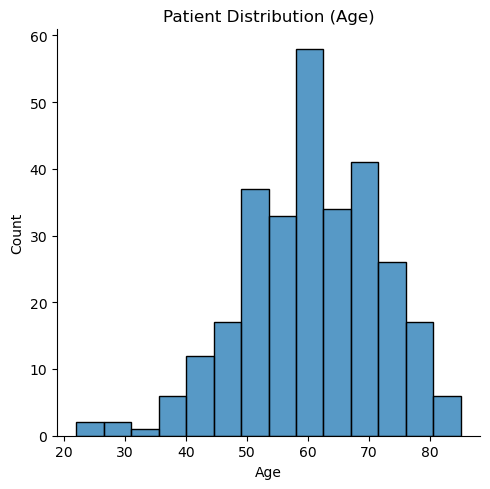

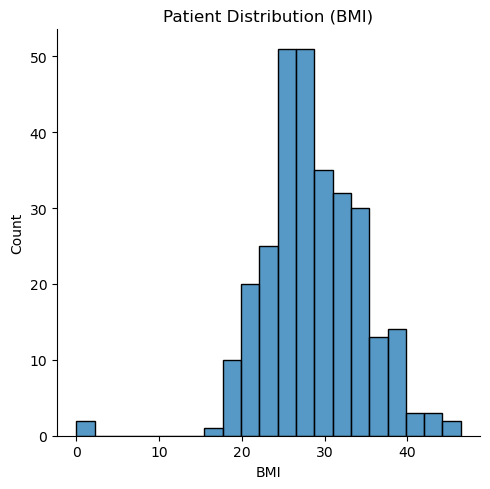

In [19]:
for c in continuous_demographic_cols:
    plot_continuous_demographics(c)

In [20]:
def plot_categorical_demographics(col):
    col_counts = clinical_metric_df[col].value_counts()
    plt.pie(col_counts, labels=None, autopct=lambda x: f'{x: .2f}%')
    plt.legend(labels=col_counts.index)
    plt.title(f"Patient Distribution ({col})")
    plt.tight_layout()
    plt.savefig(f"figures/demo_dist/{'_'.join(col.lower().split(' '))}_dist.svg")
    plt.show()

In [21]:
categorical_demographic_cols = [
    "Sex",
    "Work Status (Category)",
    "Symptom Duration"
]

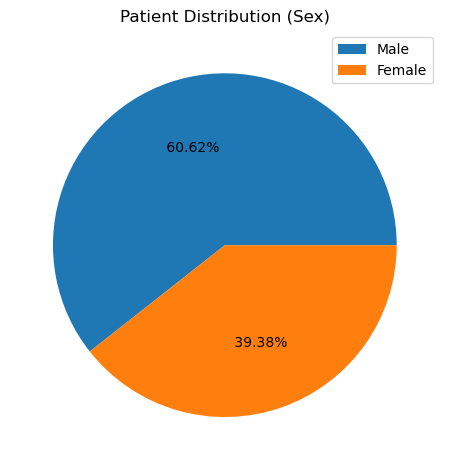

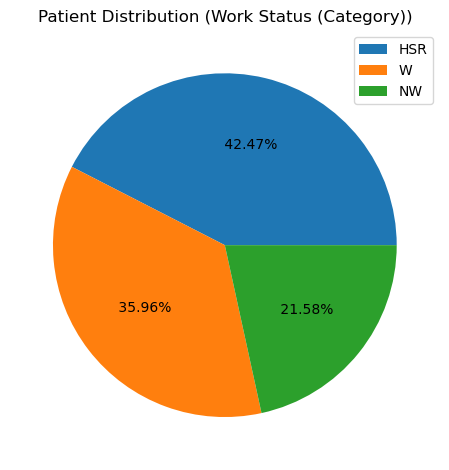

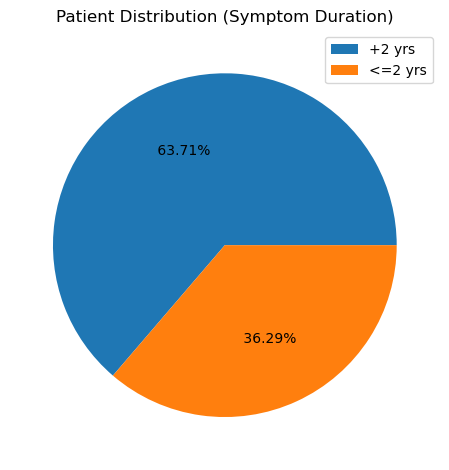

In [22]:
for c in categorical_demographic_cols:
    plot_categorical_demographics(c)

# Best By Replicate

## Re-usable Functions

In [23]:
result_df_columns = [*analysis_idx, 'Mean', 'STD']

In [24]:
# Absolute peak values by replicate, mean and std
def get_peak_of_value_test(target_value, df=performance_metric_df, n=1) -> pd.DataFrame:
    # Get the best value per analytical grouping and replicate across all trials
    peak_value_df = df.sort_values(by=target_value).groupby([*analysis_idx, 'replicate']).tail(n)

    # Set up the return dataframe
    analysis_groups = peak_value_df.reset_index().groupby(analysis_idx)
    value_means = analysis_groups[target_value].mean()
    value_stds = analysis_groups[target_value].std()
    return_df = pd.DataFrame(index=list(value_means.index))
    return_df['Mean'] = value_means
    return_df['STD'] = value_stds

    # Return the result
    return return_df

## Balanced Accuracy (Validate)

In [25]:
get_peak_of_value_test('balanced_accuracy (validate)').sort_values(['Mean', 'STD'])

Mean       STD
(clinical, LogisticRegression, none, none, pca)     0.643003  0.020297
(img, LogisticRegression, T1w, sag, rfe_pca)        0.696514  0.014057
(clinical, LogisticRegression, none, none, rfe_...  0.700967  0.013473
(img, LogisticRegression, T1w, sag, pca)            0.703880  0.019007
(img, LogisticRegression, T2w, sag, rfe_pca)        0.709006  0.026230
...                                                      ...       ...
(img, SupportVectorClassifier, T2w, axial, noprep)  1.000000  0.000000
(img, SupportVectorClassifier, T2w, axial, rfe)     1.000000  0.000000
(img, SupportVectorClassifier, T2w, sag, noprep)    1.000000  0.000000
(img, SupportVectorClassifier, T2w, sag, pca)       1.000000  0.000000
(img, SupportVectorClassifier, T2w, sag, rfe)       1.000000  0.000000

[155 rows x 2 columns]

In [26]:
get_peak_of_value_test('balanced_accuracy (validate)', n=5).sort_values(['Mean', 'STD'])

Mean       STD
(clinical, LogisticRegression, none, none, pca)     0.632170  0.027649
(img, LogisticRegression, T1w, sag, rfe_pca)        0.667458  0.025756
(img, LogisticRegression, T1w, sag, pca)            0.684179  0.021863
(img, LogisticRegression, T2w, sag, rfe_pca)        0.693366  0.030794
(clinical, LogisticRegression, none, none, rfe_...  0.695864  0.011998
...                                                      ...       ...
(img, RandomForestClassifier, T2w, sag, noprep)     1.000000  0.000000
(img, RandomForestClassifier, T2w, sag, pca)        1.000000  0.000000
(img, RandomForestClassifier, T2w, sag, rfe)        1.000000  0.000000
(img, RandomForestClassifier, T2w, sag, rfe_pca)    1.000000  0.000000
(img, SupportVectorClassifier, T1w, sag, rfe)       1.000000  0.000000

[155 rows x 2 columns]

## Balanced Accuracy (Test)

In [27]:
get_peak_of_value_test('balanced_accuracy (test)').sort_values(['Mean', 'STD'])

Mean       STD
(clinical, LogisticRegression, none, none, pca)     0.607853  0.070976
(clinical, KNNC, none, none, noprep)                0.615822  0.064587
(img, LogisticRegression, T1w, sag, rfe)            0.625000  0.085732
(img, LogisticRegression, T1w, sag, noprep)         0.635139  0.062082
(clinical, KNNC, none, none, pca)                   0.646864  0.060234
...                                                      ...       ...
(full, KNNC, T2w, axial, rfe_pca)                   0.798056  0.058560
(full, KNNC, T1w, sag, rfe)                         0.801389  0.064390
(full, RandomForestClassifier, T2w, axial, rfe_...  0.811932  0.077038
(full, KNNC, T1w, sag, rfe_pca)                     0.816250  0.060516
(full, RandomForestClassifier, T1w, sag, rfe_pca)   0.817361  0.060520

[155 rows x 2 columns]

In [28]:
get_peak_of_value_test('balanced_accuracy (test)', n=5).sort_values(['Mean', 'STD'])

Mean       STD
(clinical, LogisticRegression, none, none, pca)     0.597936  0.067858
(clinical, KNNC, none, none, noprep)                0.603535  0.067139
(img, LogisticRegression, T1w, sag, rfe)            0.612306  0.081161
(full, KNNC, T2w, sag, noprep)                      0.620971  0.080589
(img, LogisticRegression, T1w, sag, noprep)         0.626139  0.060884
...                                                      ...       ...
(img, RandomForestClassifier, T2w, axial, rfe_pca)  0.764333  0.073660
(full, AdaBoostClassifier, T2w, axial, rfe_pca)     0.764611  0.071769
(full, KNNC, T2w, axial, rfe_pca)                   0.764914  0.060735
(full, RandomForestClassifier, T1w, sag, rfe_pca)   0.769139  0.058765
(full, RandomForestClassifier, T2w, axial, rfe_...  0.779646  0.072546

[155 rows x 2 columns]

## Balanced Accuracy (Test) Weighted By Balanced Accuracy (Validated)

In [29]:
sub_df = performance_metric_df.loc[:, [*analysis_idx, *study_idxs, 'balanced_accuracy (validate)', 'balanced_accuracy (test)']]
sub_df['weighted_test'] = performance_metric_df['balanced_accuracy (test)'] * performance_metric_df['balanced_accuracy (validate)']

sub_df = sub_df.groupby([*analysis_idx, 'trial']).apply(lambda x: np.average(x['balanced_accuracy (test)'], weights=x['balanced_accuracy (validate)']))
sub_df = sub_df.reset_index()

/tmp/ipykernel_23766/2205890186.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_df = sub_df.groupby([*analysis_idx, 'trial']).apply(lambda x: np.average(x['balanced_accuracy (test)'], weights=x['balanced_accuracy (validate)']))


In [30]:
sub_df.sort_values(by=0).groupby(analysis_idx).tail(1)

dataset                    model weight    ori     prep  trial  \
127    clinical       AdaBoostClassifier   none   none      pca     27   
916    clinical       LogisticRegression   none   none      pca     16   
4624       full                     KNNC    T2w    sag      pca     24   
14504       img  SupportVectorClassifier    T1w    sag      rfe      4   
12154       img       LogisticRegression    T1w    sag      rfe     54   
...         ...                      ...    ...    ...      ...    ...   
2596       full       AdaBoostClassifier    T2w  axial   noprep     96   
6961       full   RandomForestClassifier    T1w    sag  rfe_pca     61   
1193   clinical       LogisticRegression   none   none  rfe_pca     93   
4326       full                     KNNC    T2w  axial      rfe     26   
5963       full       LogisticRegression    T2w  axial  rfe_pca     63   

              0  
127    0.542876  
916    0.548077  
4624   0.550183  
14504  0.553285  
12154  0.559360  
...         ...  
2596   0.677535  
6961   0.680131  
1193   0.682873  
4326   0.682955  
5963   0.686625  

[155 rows x 7 columns]

# Performance Across Trials

## Utility Functions

In [31]:
def plot_average_performance_across_trials(df, metric, grouping, fpath):
    # Plot the average and standard deviation
    sns.lineplot(data=df, x='trial', y=metric, hue=grouping)

    # Add details
    plt.title(f'By {grouping.capitalize()} (Average)')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(fpath)
    plt.show()

In [32]:
def plot_max_performance_across_trials(df, metric, grouping, fpath):
    # Reformat the data to be max by trial/replicate grouping
    tmp_df = df.groupby(['replicate', 'trial', grouping])[metric].max().reset_index()
    
    # Plot the average and standard deviation
    sns.lineplot(data=tmp_df, x='trial', y=metric, hue=grouping)

    # Add details
    plt.title(f'By {grouping.capitalize()} (Max)')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(fpath)
    plt.show()

## Balanced Accuracy (Test)

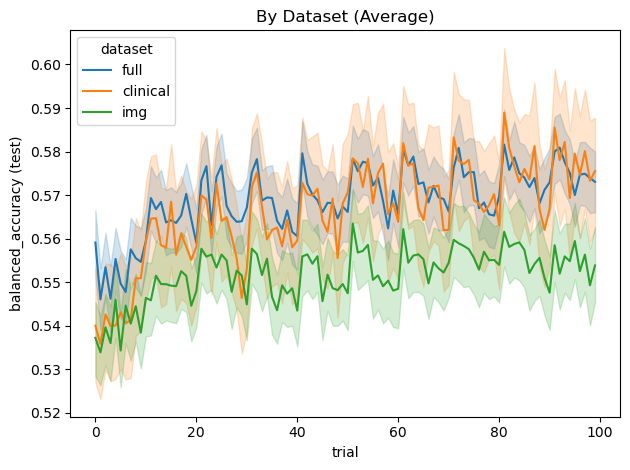

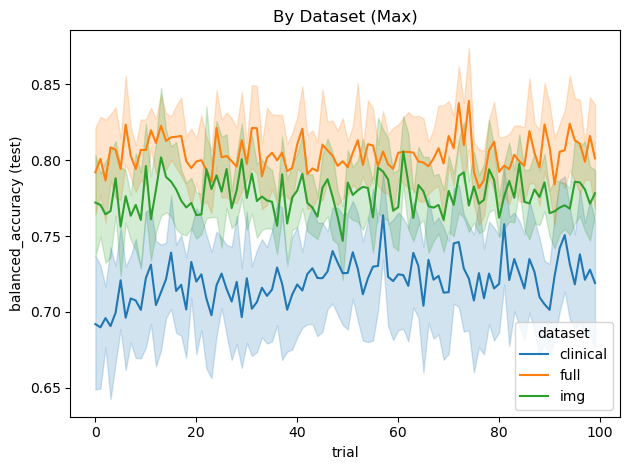

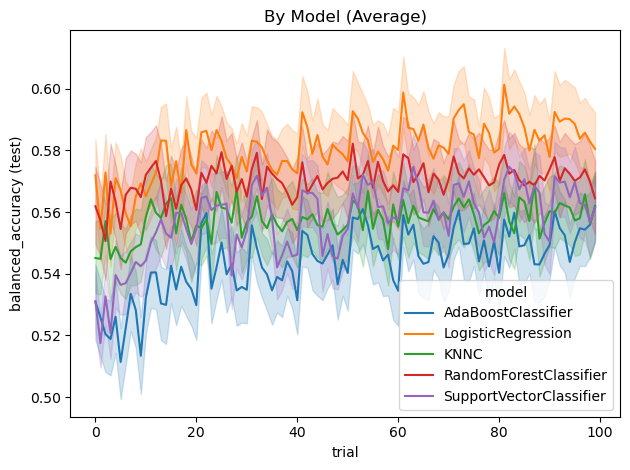

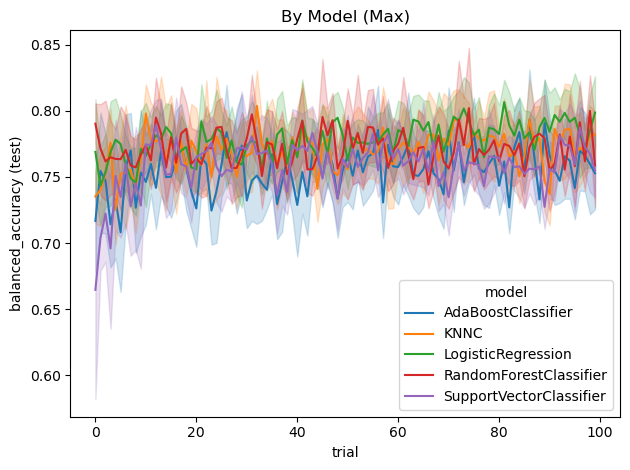

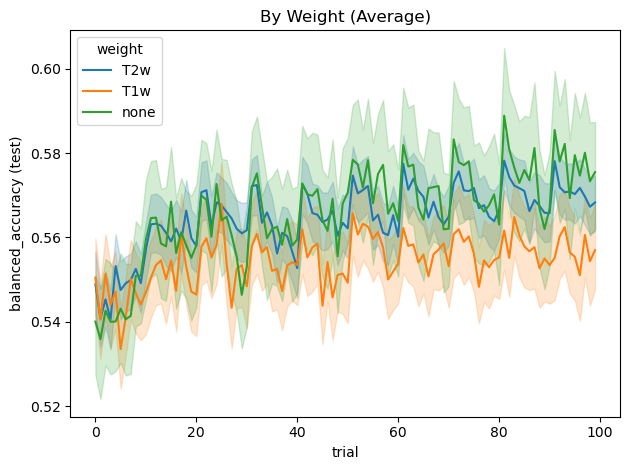

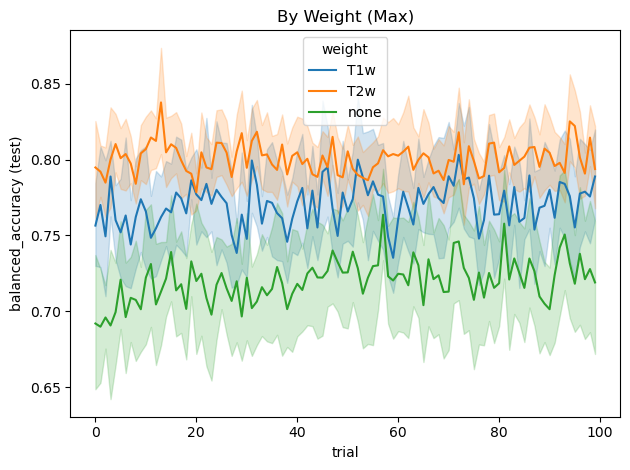

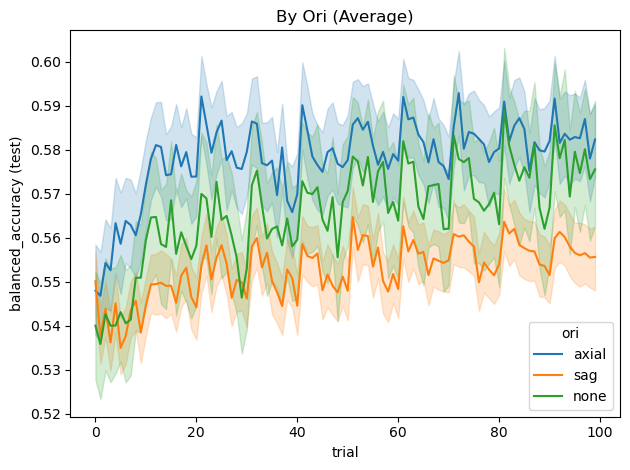

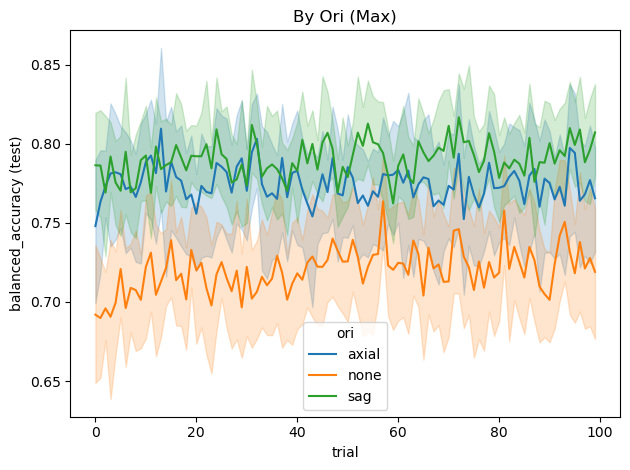

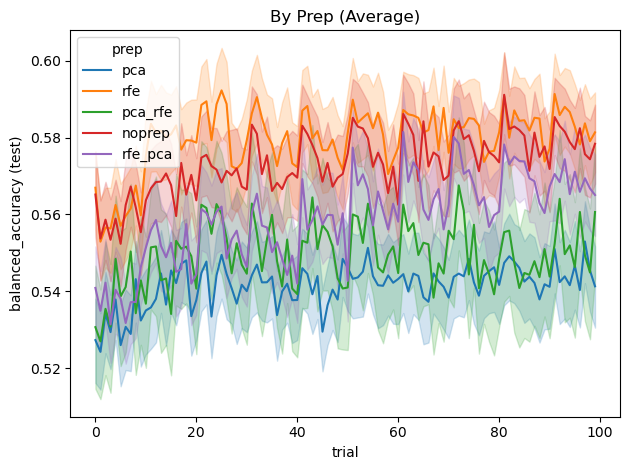

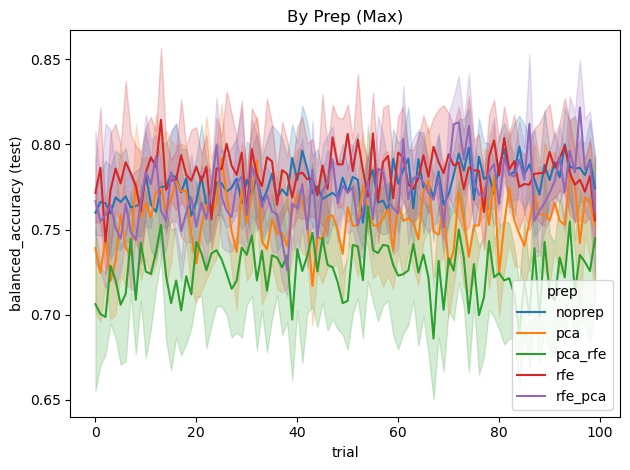

In [33]:
output_dir = Path("figures/bacc_performance/")
for i in analysis_idx:
    plot_average_performance_across_trials(performance_metric_df, 'balanced_accuracy (test)', i, output_dir/f'bacc_avg_by_{i}.png')
    plot_max_performance_across_trials(performance_metric_df, 'balanced_accuracy (test)', i, output_dir/f'bacc_max_by_{i}.png')

## Balanced Accuracy (Test) at Peak Balanced Accuarcy (Validate)

In [34]:
def plot_metric_at_peak_other_across_trials(df, metric, other, grouping, fpath):
    # Reformat the data to be max by trial/replicate grouping
    tmp_df = df.sort_values(other).groupby(['replicate', 'trial', grouping]).tail(1).reset_index()
    
    # Plot the average and standard deviation
    sns.lineplot(data=tmp_df, x='trial', y=metric, hue=grouping)

    # Add details
    plt.title(f'By {grouping.capitalize()} (B.Acc Test @ Peak Validation)')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(fpath)
    plt.show()

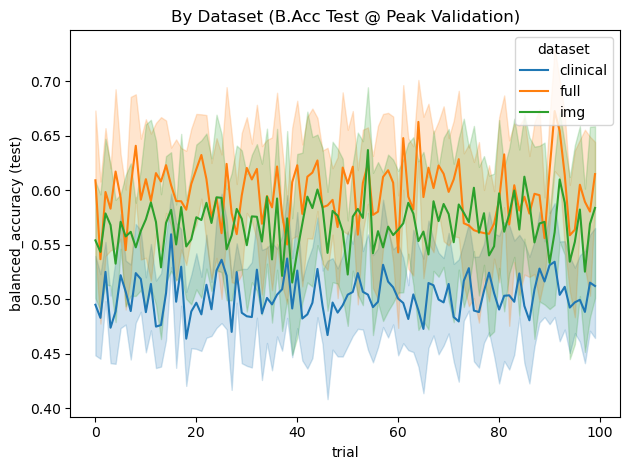

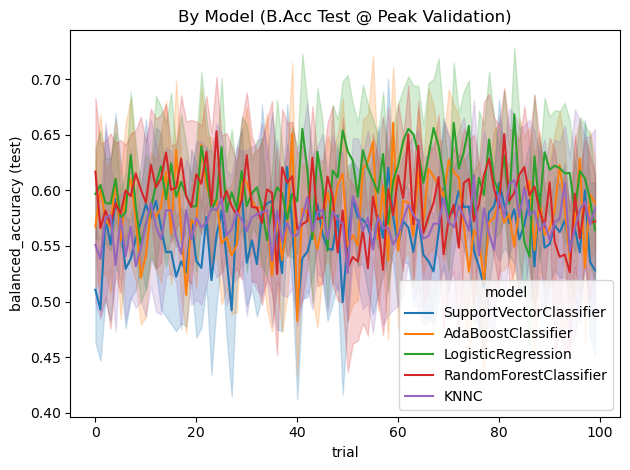

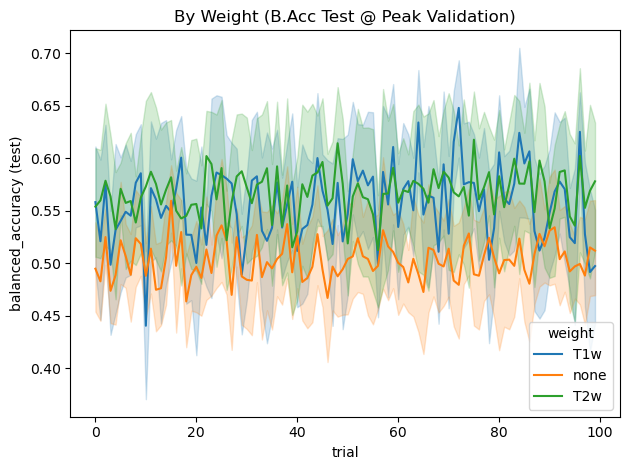

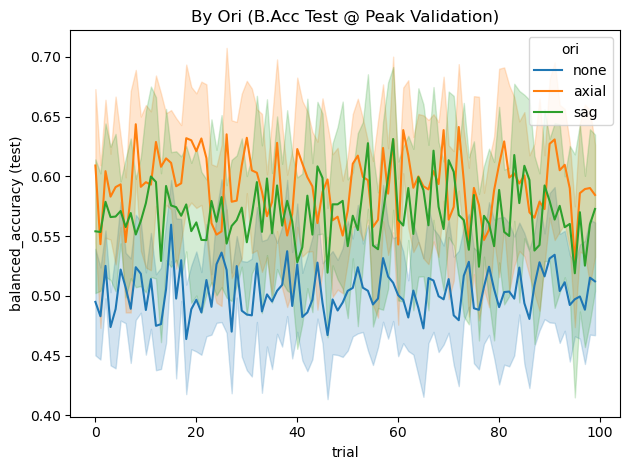

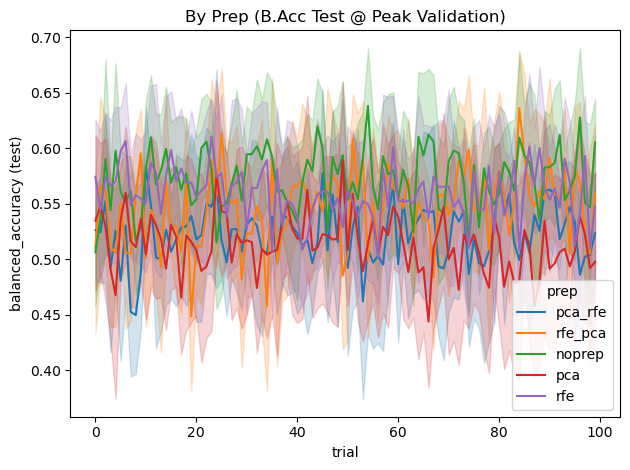

In [35]:
for i in analysis_idx:
    plot_metric_at_peak_other_across_trials(performance_metric_df, 'balanced_accuracy (test)', 'balanced_accuracy (validate)', i, output_dir/f'bacc_test_at_peak_validate_by_{i}.png')

## Balanced Accuracy (Test) Weighted by Balanced Accuracy (Validated)


In [36]:
def weighted_std(vals, weights):
    mean_val = np.average(vals, weights=weights)
    std_vals = np.average((vals-mean_val)**2, weights=weights)
    return std_vals

In [37]:
def metric_weighted_by_other(df, metric, weight, grouping, fpath):
    # Calculate the weighted metrics from the original dataset
    df_groupedby = df.loc[:, [grouping, *study_idxs, metric, weight]].groupby([grouping, 'trial'])
    mean_vals = df_groupedby.apply(lambda x: np.average(x[metric], weights=x[weight]), include_groups=False)
    std_vals = df_groupedby.apply(lambda x: weighted_std(x[metric], x[weight]), include_groups=False)
    
    sub_df = pd.DataFrame()
    sub_df['Mean'] = mean_vals
    sub_df['STD'] = std_vals

    # Plot each of them iteratively, w/ weighted mean and std
    fig, ax = plt.subplots(1)
    group_options = set(df[grouping])
    for i, g in enumerate(group_options):
        # Plot the main line
        y = sub_df.reset_index().query(f"{grouping} == '{g}'")
        y_mean = y.groupby('trial')['Mean'].mean()
        ax.plot(y_mean, label=g)

        # Plot the (weighted) standard deviation fills
        y_std = y.groupby('trial')['STD'].mean()
        ax.fill_between(np.arange(y_std.shape[0]), y_mean+y_std, y_mean-y_std, facecolor=f'C{i}', alpha=0.4)

    # Add other plotted elements
    plt.xlabel('Trial')
    plt.ylabel('Weighted Average')
    plt.legend(title=grouping)
    plt.show()

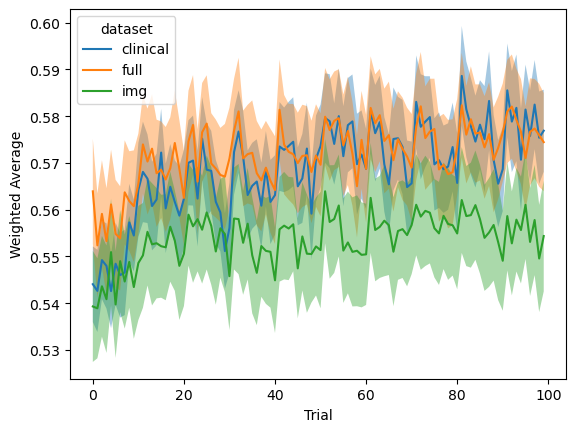

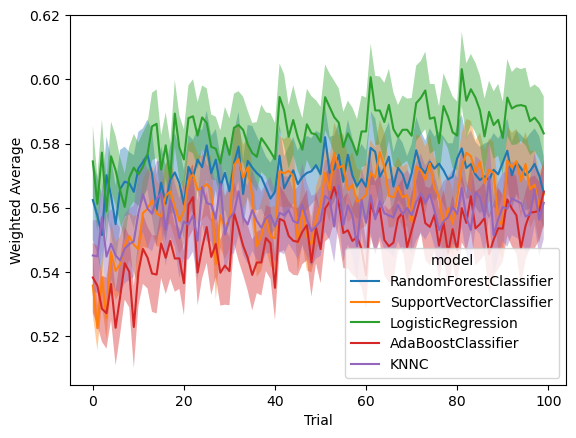

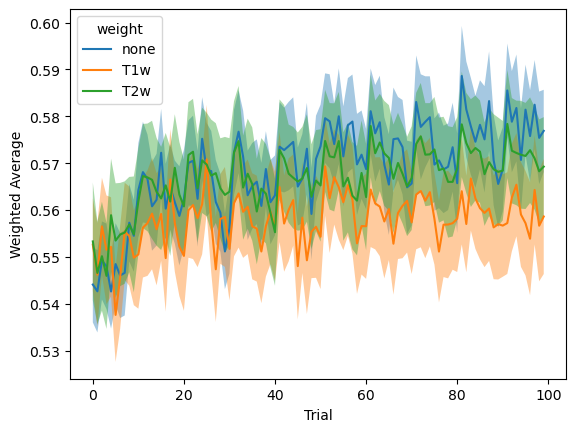

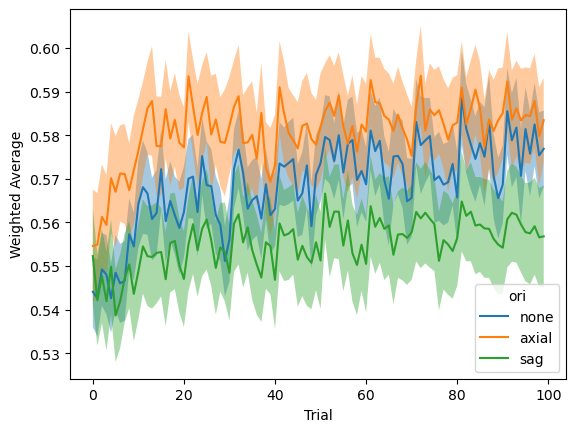

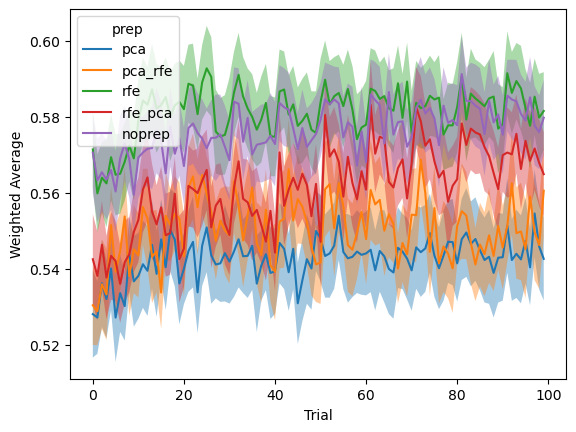

In [38]:
for i in analysis_idx:
    metric_weighted_by_other(performance_metric_df, 'balanced_accuracy (test)', 'balanced_accuracy (validate)', i, output_dir/f'bacc_weighted_avg_by_{i}.png')

# Paired T-Tests

## Setup

In [39]:
from itertools import combinations, permutations

from scipy.stats import normaltest, ranksums, kruskal

Target metric gathering function

In [40]:
# Absolute peak values by replicate, mean and std
def get_best_per_replicate(target_value):
    component_dfs = []
    for k, df in df_map.items():
        peak_df = df.sort_values(by=target_value).groupby('replicate').last()
        peak_df = peak_df.loc[:, [*analysis_idx, 'trial', target_value]]
        component_dfs.append(peak_df)
    result_df = pd.concat(component_dfs).reset_index()
    return result_df

In [41]:
# Values of one metric, sampled at the peak value of another, per-replicate mean and STD sampled
def get_val_at_best_other_per_replicate(target, other):
    component_dfs = []
    for k, df in df_map.items():
        peak_df = df.sort_values(by=other).groupby('replicate').last()
        peak_df = peak_df.loc[:, [*analysis_idx, 'trial', target]]
        component_dfs.append(peak_df)
    result_df = pd.concat(component_dfs).reset_index()
    return result_df

In [42]:
def evaluate_normality(df, query_key, target):
    isnormal = {}
    query_set = set(replicate_best_bacc_df[query_key])

    for k in query_set:
        x = df.query(f"{query_key} == '{k}'")[target]
        isnormal[k] = [normaltest(x).pvalue]

    # Save the results as a dataframe
    return_df = pd.DataFrame.from_dict(isnormal).T
    return_df.columns = ['p-value']
    return return_df

In [43]:
alt_keys = {
    'two-sided': '!=',
    'greater':   '>',
    'less':      '<'
}

def paired_rankedsum(df, query, target, alternative='two-sided'):
    pvals = {}
    query_set = set(df[query])

    # Caclulate the native rankedsum p-value for each pair of datasets, testing whether the former's value is greater than the latters
    for v1, v2 in permutations(query_set, 2):
        x1 = df.query(f"{query} == '{v1}'")[target]
        x2 = df.query(f"{query} == '{v2}'")[target]
        p = ranksums(x1, x2, alternative=alternative).pvalue
        pvals[f"{v1} {alt_keys[alternative]} {v2}"] = [p]

    # Save the results as a dataframe
    return_df = pd.DataFrame.from_dict(pvals).T
    return_df.index.name = 'Comparison'
    return_df.columns = ['p']
    return return_df

In [44]:
def evaluate_kw(df, grouping, target):
    query_set = set(df[grouping])
    samples = [df.query(f"{grouping} == '{q}'")[target] for q in query_set]
    return kruskal(*samples).pvalue

## Testing Balanced Accuracy

### Peak Testing

Raw Values

In [45]:
target = 'balanced_accuracy (test)'
replicate_best_bacc_df = get_best_per_replicate(target)
replicate_best_bacc_df

replicate dataset                    model weight    ori prep  trial  \
0             0    full       AdaBoostClassifier    T2w  axial  pca     65   
1             1    full       AdaBoostClassifier    T2w  axial  pca     49   
2             2    full       AdaBoostClassifier    T2w  axial  pca     53   
3             3    full       AdaBoostClassifier    T2w  axial  pca     58   
4             4    full       AdaBoostClassifier    T2w  axial  pca     13   
...         ...     ...                      ...    ...    ...  ...    ...   
1545          5     img  SupportVectorClassifier    T2w    sag  rfe     79   
1546          6     img  SupportVectorClassifier    T2w    sag  rfe     12   
1547          7     img  SupportVectorClassifier    T2w    sag  rfe     64   
1548          8     img  SupportVectorClassifier    T2w    sag  rfe     70   
1549          9     img  SupportVectorClassifier    T2w    sag  rfe     46   

      balanced_accuracy (test)  
0                     0.787879  
1                     0.621212  
2                     0.641414  
3                     0.676136  
4                     0.788889  
...                        ...  
1545                  0.767857  
1546                  0.809524  
1547                  0.702381  
1548                  0.714286  
1549                  0.769231  

[1550 rows x 8 columns]

Ranked-Sum Grouping Comparisons

In [46]:
# Calculate the p-values for whether one experimental permutation has greater average balanced accuracy performance than another
sub_dfs = []
for k in analysis_idx:
    tmp_df = paired_rankedsum(replicate_best_bacc_df, k, target, alternative='greater')
    sub_dfs.append(tmp_df)

sig_df = pd.concat(sub_dfs).sort_values('p')

# Calculate the corrected p-value significance as well
n_samples = sig_df.shape[0]
sig_df['significance'] = ''
for i, t in enumerate([0.05, 0.01, 0.001]):
    sig_df.loc[sig_df['p']*n_samples < t, 'significance'] = '*'*(i+1)

sig_df.reset_index()

Comparison             p  \
0                                   rfe_pca > noprep  3.284616e-16   
1                                      rfe_pca > pca  3.275532e-15   
2                                        axial > sag  1.596018e-10   
3                                       axial > none  3.792806e-09   
4                                    full > clinical  1.103812e-07   
5                                         full > img  2.306407e-07   
6        RandomForestClassifier > LogisticRegression  2.344136e-07   
7                                      rfe_pca > rfe  8.965048e-06   
8                                       rfe > noprep  1.516951e-05   
9                                         T1w > none  3.585196e-05   
10                                         rfe > pca  4.551336e-05   
11                                  pca_rfe > noprep  9.006736e-05   
12                                     pca_rfe > pca  2.246510e-04   
13                                        T2w > none  3.335015e-04   
14       RandomForestClassifier > AdaBoostClassifier  1.242127e-03   
15                                 rfe_pca > pca_rfe  1.426643e-03   
16  RandomForestClassifier > SupportVectorClassifier  3.271929e-03   
17                         KNNC > LogisticRegression  5.027678e-03   
18      SupportVectorClassifier > LogisticRegression  5.488543e-03   
19                     RandomForestClassifier > KNNC  6.167773e-03   
20                                        sag > none  7.752662e-03   
21           AdaBoostClassifier > LogisticRegression  9.738892e-03   
22                                    img > clinical  4.702175e-02   
23                                         T1w > T2w  2.022275e-01   
24                         KNNC > AdaBoostClassifier  3.348916e-01   
25                                     pca_rfe > rfe  3.410279e-01   
26                                      pca > noprep  3.531569e-01   
27      SupportVectorClassifier > AdaBoostClassifier  3.967085e-01   
28                    KNNC > SupportVectorClassifier  4.528823e-01   
29                    SupportVectorClassifier > KNNC  5.471177e-01   
30      AdaBoostClassifier > SupportVectorClassifier  6.032915e-01   
31                                      noprep > pca  6.468431e-01   
32                                     rfe > pca_rfe  6.589721e-01   
33                         AdaBoostClassifier > KNNC  6.651084e-01   
34                                         T2w > T1w  7.977725e-01   
35                                    clinical > img  9.529782e-01   
36           LogisticRegression > AdaBoostClassifier  9.902611e-01   
37                                        none > sag  9.922473e-01   
38                     KNNC > RandomForestClassifier  9.938322e-01   
39      LogisticRegression > SupportVectorClassifier  9.945115e-01   
40                         LogisticRegression > KNNC  9.949723e-01   
41  SupportVectorClassifier > RandomForestClassifier  9.967281e-01   
42                                 pca_rfe > rfe_pca  9.985734e-01   
43       AdaBoostClassifier > RandomForestClassifier  9.987579e-01   
44                                        none > T2w  9.996665e-01   
45                                     pca > pca_rfe  9.997753e-01   
46                                  noprep > pca_rfe  9.999099e-01   
47                                         pca > rfe  9.999545e-01   
48                                        none > T1w  9.999641e-01   
49                                      noprep > rfe  9.999848e-01   
50                                     rfe > rfe_pca  9.999910e-01   
51       LogisticRegression > RandomForestClassifier  9.999998e-01   
52                                        img > full  9.999998e-01   
53                                   clinical > full  9.999999e-01   
54                                      none > axial  1.000000e+00   
55                                       sag > axial  1.000000e+00   
56                                     pca > rfe_pca

Kruskal-Wallace

In [47]:
# Using Kruskal-Wallace, confirm that there is a significant difference in the best-case performance for each analytical variation
kw_pvals = {}
for i in analysis_idx:
    kw_pvals[i] = [evaluate_kw(replicate_best_bacc_df, i, 'balanced_accuracy (test)')]
kw_df = pd.DataFrame.from_dict(kw_pvals).T
kw_df.columns = ['p']

# Calculate the corrected p-value significance as well w/ Bonferroni correction
kw_df['significance'] = ''
n_samples = kw_df.shape[0]
for i, t in enumerate([0.05, 0.01, 0.001]):
    kw_df.loc[kw_df['p']*n_samples < t, 'significance'] = '*'*(i+1)

kw_df

p significance
dataset  2.007435e-09          ***
model    2.165260e-05          ***
weight   4.470740e-04           **
ori      3.975111e-12          ***
prep     6.362026e-19          ***

### Testing @ Peak Validation

Raw Performance

In [48]:
target = 'balanced_accuracy (test)'
other = 'balanced_accuracy (validate)'
replicate_test_at_peak_bacc_df = get_val_at_best_other_per_replicate(target, other)
replicate_test_at_peak_bacc_df

replicate dataset                    model weight    ori prep  trial  \
0             0    full       AdaBoostClassifier    T2w  axial  pca     24   
1             1    full       AdaBoostClassifier    T2w  axial  pca     42   
2             2    full       AdaBoostClassifier    T2w  axial  pca     59   
3             3    full       AdaBoostClassifier    T2w  axial  pca     54   
4             4    full       AdaBoostClassifier    T2w  axial  pca     13   
...         ...     ...                      ...    ...    ...  ...    ...   
1545          5     img  SupportVectorClassifier    T2w    sag  rfe     58   
1546          6     img  SupportVectorClassifier    T2w    sag  rfe     14   
1547          7     img  SupportVectorClassifier    T2w    sag  rfe      3   
1548          8     img  SupportVectorClassifier    T2w    sag  rfe     88   
1549          9     img  SupportVectorClassifier    T2w    sag  rfe     68   

      balanced_accuracy (test)  
0                     0.560606  
1                     0.550505  
2                     0.494949  
3                     0.505682  
4                     0.788889  
...                        ...  
1545                  0.726190  
1546                  0.690476  
1547                  0.517857  
1548                  0.672619  
1549                  0.576923  

[1550 rows x 8 columns]

Ranked-Sum Grouping Comparisons

In [49]:
# Calculate the p-values for whether one experimental permutation has greater average balanced accuracy performance than another
sub_dfs = []
for k in analysis_idx:
    tmp_df = paired_rankedsum(replicate_test_at_peak_bacc_df, k, target, alternative='greater')
    sub_dfs.append(tmp_df)

sig_test_at_peak_valid_df = pd.concat(sub_dfs).sort_values('p')

# Calculate the corrected p-value significance as well
n_samples = sig_df.shape[0]
sig_test_at_peak_valid_df['significance'] = ''
for i, t in enumerate([0.05, 0.01, 0.001]):
    sig_test_at_peak_valid_df.loc[sig_test_at_peak_valid_df['p']*n_samples < t, 'significance'] = '*'*(i+1)

sig_test_at_peak_valid_df.reset_index()

Comparison         p significance
0            LogisticRegression > AdaBoostClassifier  0.000005          ***
1                          LogisticRegression > KNNC  0.000011          ***
2                                       noprep > pca  0.000013          ***
3                                      rfe_pca > pca  0.000043           **
4                                        axial > sag  0.000050           **
5                                          rfe > pca  0.000055           **
6                                         full > img  0.000877             
7                                   noprep > pca_rfe  0.000900             
8       LogisticRegression > SupportVectorClassifier  0.001502             
9                                  rfe_pca > pca_rfe  0.001685             
10                                     rfe > pca_rfe  0.002052             
11       RandomForestClassifier > AdaBoostClassifier  0.003731             
12                     RandomForestClassifier > KNNC  0.004995             
13                                    clinical > img  0.024704             
14                                        none > sag  0.041443             
15       LogisticRegression > RandomForestClassifier  0.067483             
16                    SupportVectorClassifier > KNNC  0.070792             
17      SupportVectorClassifier > AdaBoostClassifier  0.084485             
18  RandomForestClassifier > SupportVectorClassifier  0.096576             
19                                      axial > none  0.136269             
20                                        none > T1w  0.158178             
21                                         T2w > T1w  0.187598             
22                                        none > T2w  0.276662             
23                                      noprep > rfe  0.376686             
24                                   full > clinical  0.392734             
25                                     rfe_pca > rfe  0.418113             
26                         AdaBoostClassifier > KNNC  0.450840             
27                                  noprep > rfe_pca  0.452761             
28                                     pca_rfe > pca  0.493264             
29                                     pca > pca_rfe  0.506736             
30                                  rfe_pca > noprep  0.547239             
31                         KNNC > AdaBoostClassifier  0.549160             
32                                     rfe > rfe_pca  0.581887             
33                                   clinical > full  0.607266             
34                                      rfe > noprep  0.623314             
35                                        T2w > none  0.723338             
36                                         T1w > T2w  0.812402             
37                                        T1w > none  0.841822             
38                                      none > axial  0.863731             
39  SupportVectorClassifier > RandomForestClassifier  0.903424             
40      AdaBoostClassifier > SupportVectorClassifier  0.915515             
41                    KNNC > SupportVectorClassifier  0.929208             
42       RandomForestClassifier > LogisticRegression  0.932517             
43                                        sag > none  0.958557             
44                                    img > clinical  0.975296             
45                     KNNC > RandomForestClassifier  0.995005             
46       AdaBoostClassifier > RandomForestClassifier  0.996269             
47                                     pca_rfe > rfe  0.997948             
48                                 pca_rfe > rfe_pca  0.998315             
49      SupportVectorClassifier > LogisticRegression  0.998498             
50                                  pca_rfe > noprep  0.999100             
51                                        img > full  0.999123             
52            

Kruskal-Wallace 

In [50]:
# Using Kruskal-Wallace, confirm that there is a significant difference in the best-case performance for each analytical variation
kw_pvals = {}
for i in analysis_idx:
    kw_pvals[i] = [evaluate_kw(replicate_test_at_peak_bacc_df, i, 'balanced_accuracy (test)')]
kw_df = pd.DataFrame.from_dict(kw_pvals).T
kw_df.columns = ['p']

# Calculate the corrected p-value significance as well w/ Bonferroni correction
kw_df['significance'] = ''
n_samples = kw_df.shape[0]
for i, t in enumerate([0.05, 0.01, 0.001]):
    kw_df.loc[kw_df['p']*n_samples < t, 'significance'] = '*'*(i+1)

kw_df

p significance
dataset  0.005082            *
model    0.000017          ***
weight   0.508953             
ori      0.000366           **
prep     0.000004          ***

# Feature Importance

In [51]:
def format_feature_imp(val):
    # Strip leading and trailing brackets
    val = val[1:-2]

    # Create a dictionary from the remaining components
    imp_dict = dict()
    for v in val.split(', '):
        vcomps = v.split(': ')
        k = ': '.join(vcomps[:-1])
        v = float(vcomps[-1])
        imp_dict[k] = v
        
    return imp_dict

In [52]:
def feature_importance_report(df: pd.DataFrame, weight_col, feature_col):
    # Convert the dictionaries contained with the feature_col dicts into dataframes which can be stacked
    raw_dfs = []
    weighted_dfs = []
    for r in df.iterrows():
        rvals = r[1]
        tmp_df = pd.DataFrame.from_dict({k: [v] for k, v in rvals[feature_col].items()})
        weight = rvals[weight_col]
        raw_dfs.append(tmp_df)
        weighted_dfs.append(tmp_df * weight)

    # Stack the dataframes
    raw_feature_imps = pd.concat(raw_dfs).fillna(0)
    weighted_feature_imps = pd.concat(weighted_dfs).fillna(0)

    # Interpret the results into a clean report
    feature_imp_report = {
        "Mean (Raw)": raw_feature_imps.mean(),
        "STD (Raw)": raw_feature_imps.std(),
        "Mean (Magnitude)": np.abs(raw_feature_imps).mean(),
        "STD (Magnitude)": np.abs(raw_feature_imps).std(),
        "Mean (Performance Weighted)": weighted_feature_imps.mean(),
        "STD (Performance Weighted)": weighted_feature_imps.std(),
    }
    result_df = pd.DataFrame.from_dict(feature_imp_report)
    
    return result_df

In [53]:
# Isolate and stack the information relative to the value
sub_dfs = []

for df in df_map.values():
    tmp_df = df.loc[:, [*study_idxs, *analysis_idx, 'balanced_accuracy (test)', 'importance_by_permutation (test)']]
    sub_dfs.append(tmp_df)

feature_imp_df = pd.concat(sub_dfs)

# Isolate only the best trial from each replicate
feature_imp_df = feature_imp_df.sort_values('balanced_accuracy (test)').groupby([*analysis_idx, 'replicate']).tail(1).set_index(analysis_idx)

# Parse the feature importance list into a cleaner dictionary
feature_imp_df['importance_by_permutation (test)'] = feature_imp_df['importance_by_permutation (test)'].apply(format_feature_imp)
feature_imp_df

replicate  trial  \
dataset model                  weight ori   prep                        
img     KNNC                   T2w    axial pca              1     95   
full    RandomForestClassifier T2w    sag   noprep           3     47   
img     RandomForestClassifier T2w    sag   noprep           3     96   
                                            pca              3     68   
full    RandomForestClassifier T2w    axial noprep           1     47   
...                                                        ...    ...   
img     KNNC                   T1w    sag   pca              3     22   
full    KNNC                   T1w    sag   rfe              3      6   
        RandomForestClassifier T1w    sag   rfe_pca          9      2   
                                            rfe              8     52   
img     KNNC                   T2w    axial rfe              4     13   

                                                     balanced_accuracy (test)  \
dataset model                  weight ori   prep                                
img     KNNC                   T2w    axial pca                      0.449495   
full    RandomForestClassifier T2w    sag   noprep                   0.452381   
img     RandomForestClassifier T2w    sag   noprep                   0.458333   
                                            pca                      0.494048   
full    RandomForestClassifier T2w    axial noprep                   0.494949   
...                                                                       ...   
img     KNNC                   T1w    sag   pca                      0.937500   
full    KNNC                   T1w    sag   rfe                      0.937500   
        RandomForestClassifier T1w    sag   rfe_pca                  0.944444   
                                            rfe                      0.944444   
img     KNNC                   T2w    axial rfe                      0.944444   

                                                                      importance_by_permutation (test)  
dataset model                  weight ori   prep                                                        
img     KNNC                   T2w    axial pca      {'PC8': 0.22000000000000003, 'PC3': 0.15, 'PC1...  
full    RandomForestClassifier T2w    sag   noprep   {'STD(area) [V2]': 0.08461538461538463, 'MEAN(...  
img     RandomForestClassifier T2w    sag   noprep   {'MEAN(angle_AP) [V2]': 0.06923076923076925, '...  
                                            pca      {'PC5': 0.0769230769230769, 'PC13': 0.06923076...  
full    RandomForestClassifier T2w    axial noprep   {'MEAN(area) [V3]': 0.07999999999999999, 'MEAN...  
...                                                                                                ...  
img     KNNC                   T1w    sag   pca      {'PC0': 0.2444444444444444, 'PC4': 0.166666666...  
full    KNNC                   T1w    sag   rfe      {'MEAN(area) [V2]': 0.16666666666666666, 'BMI'...  
        RandomForestClassifier T1w    sag   rfe_pca  {'PC1': 0.31111111111111106, 'PC4': 0.25555555...  
                                            rfe      {'Age': 0.2444444444444444, 'MEAN(area) [V2]':...  
img     KNNC                   T2w    axial rfe      {'MEAN(eccentricity) [V4]': 0.2105263157894736...  

[1550 rows x 4 columns]

### PCA

In [54]:
def is_pca(val): return 'pca' in val 

pca_feature_imp_df = feature_imp_df.reset_index().loc[feature_imp_df.reset_index()['prep'].apply(is_pca), :].set_index([*analysis_idx])
pca_feature_imp_df

replicate  trial  \
dataset model                   weight ori   prep                        
img     KNNC                    T2w    axial pca              1     95   
        RandomForestClassifier  T2w    sag   pca              3     68   
full    LogisticRegression      T2w    axial pca              1     47   
img     LogisticRegression      T2w    sag   pca              3     76   
                                             rfe_pca          3      8   
...                                                         ...    ...   
full    SupportVectorClassifier T2w    axial pca_rfe          0     94   
        KNNC                    T1w    sag   rfe_pca          2     86   
        AdaBoostClassifier      T2w    axial rfe_pca          5     86   
img     KNNC                    T1w    sag   pca              3     22   
full    RandomForestClassifier  T1w    sag   rfe_pca          9      2   

                                                      balanced_accuracy (test)  \
dataset model                   weight ori   prep                                
img     KNNC                    T2w    axial pca                      0.449495   
        RandomForestClassifier  T2w    sag   pca                      0.494048   
full    LogisticRegression      T2w    axial pca                      0.500000   
img     LogisticRegression      T2w    sag   pca                      0.500000   
                                             rfe_pca                  0.500000   
...                                                                        ...   
full    SupportVectorClassifier T2w    axial pca_rfe                  0.898990   
        KNNC                    T1w    sag   rfe_pca                  0.900000   
        AdaBoostClassifier      T2w    axial rfe_pca                  0.900000   
img     KNNC                    T1w    sag   pca                      0.937500   
full    RandomForestClassifier  T1w    sag   rfe_pca                  0.944444   

                                                                       importance_by_permutation (test)  
dataset model                   weight ori   prep                                                        
img     KNNC                    T2w    axial pca      {'PC8': 0.22000000000000003, 'PC3': 0.15, 'PC1...  
        RandomForestClassifier  T2w    sag   pca      {'PC5': 0.0769230769230769, 'PC13': 0.06923076...  
full    LogisticRegression      T2w    axial pca      {'PC0': 0.0, 'PC1': 0.0, 'PC2': 0.0, 'PC3': 0....  
img     LogisticRegression      T2w    sag   pca      {'PC0': 0.0, 'PC1': 0.0, 'PC2': 0.0, 'PC3': 0....  
                                             rfe_pca                           {'PC0': 0.0, 'PC1': 0.0}  
...                                                                                                 ...  
full    SupportVectorClassifier T2w    axial pca_rfe  {'PC18': 0.17, 'PC25': 0.15000000000000005, 'P...  
        KNNC                    T1w    sag   rfe_pca  {'PC12': 0.22222222222222218, 'PC7': 0.2111111...  
        AdaBoostClassifier      T2w    axial rfe_pca  {'PC4': 0.25263157894736843, 'PC11': 0.1368421...  
img     KNNC                    T1w    sag   pca      {'PC0': 0.2444444444444444, 'PC4': 0.166666666...  
full    RandomForestClassifier  T1w    sag   rfe_pca  {'PC1': 0.31111111111111106, 'PC4': 0.25555555...  

[850 rows x 4 columns]

### Raw Features

In [55]:
nonpca_feature_imp_df = feature_imp_df.drop(pca_feature_imp_df.index)
nonpca_feature_imp_df

replicate  trial  \
dataset model                  weight ori   prep                       
full    RandomForestClassifier T2w    sag   noprep          3     47   
img     RandomForestClassifier T2w    sag   noprep          3     96   
full    RandomForestClassifier T2w    axial noprep          1     47   
img     LogisticRegression     T2w    axial noprep          1     79   
                                      sag   noprep          3     27   
...                                                       ...    ...   
        AdaBoostClassifier     T2w    axial rfe             2     13   
                                            noprep          2     62   
full    KNNC                   T1w    sag   rfe             3      6   
        RandomForestClassifier T1w    sag   rfe             8     52   
img     KNNC                   T2w    axial rfe             4     13   

                                                    balanced_accuracy (test)  \
dataset model                  weight ori   prep                               
full    RandomForestClassifier T2w    sag   noprep                  0.452381   
img     RandomForestClassifier T2w    sag   noprep                  0.458333   
full    RandomForestClassifier T2w    axial noprep                  0.494949   
img     LogisticRegression     T2w    axial noprep                  0.500000   
                                      sag   noprep                  0.500000   
...                                                                      ...   
        AdaBoostClassifier     T2w    axial rfe                     0.898990   
                                            noprep                  0.898990   
full    KNNC                   T1w    sag   rfe                     0.937500   
        RandomForestClassifier T1w    sag   rfe                     0.944444   
img     KNNC                   T2w    axial rfe                     0.944444   

                                                                     importance_by_permutation (test)  
dataset model                  weight ori   prep                                                       
full    RandomForestClassifier T2w    sag   noprep  {'STD(area) [V2]': 0.08461538461538463, 'MEAN(...  
img     RandomForestClassifier T2w    sag   noprep  {'MEAN(angle_AP) [V2]': 0.06923076923076925, '...  
full    RandomForestClassifier T2w    axial noprep  {'MEAN(area) [V3]': 0.07999999999999999, 'MEAN...  
img     LogisticRegression     T2w    axial noprep  {'MEAN(area) [V2]': 0.0, 'MEAN(area) [V3]': 0....  
                                      sag   noprep  {'MEAN(area) [V2]': 0.0, 'MEAN(area) [V3]': 0....  
...                                                                                               ...  
        AdaBoostClassifier     T2w    axial rfe     {'MEAN(area) [V3]': 0.52, 'MEAN(area) [V2]': 0...  
                                            noprep  {'MEAN(area) [V3]': 0.44000000000000006, 'MEAN...  
full    KNNC                   T1w    sag   rfe     {'MEAN(area) [V2]': 0.16666666666666666, 'BMI'...  
        RandomForestClassifier T1w    sag   rfe     {'Age': 0.2444444444444444, 'MEAN(area) [V2]':...  
img     KNNC                   T2w    axial rfe     {'MEAN(eccentricity) [V4]': 0.2105263157894736...  

[700 rows x 4 columns]

In [56]:
full_feature_imp_df = nonpca_feature_imp_df.query("dataset == 'full'")
full_feature_report = feature_importance_report(full_feature_imp_df, 'balanced_accuracy (test)', 'importance_by_permutation (test)')
full_feature_report.sort_values("Mean (Performance Weighted)", ascending=False).head(10)

Mean (Raw)  STD (Raw)  Mean (Magnitude)  \
Age                        0.083739   0.067443          0.085947   
mJOA initial               0.065039   0.055871          0.067827   
MEAN(area) [V2]            0.053424   0.062335          0.055929   
BMI                        0.030492   0.043874          0.034166   
MEAN(orientation) [V3]     0.029546   0.039165          0.031660   
MEAN(area) [V3]            0.025911   0.047712          0.027583   
STD(eccentricity) [V5]     0.025714   0.037526          0.027393   
MEAN(eccentricity) [V4]    0.024285   0.038108          0.025629   
MEAN(diameter_AP) [V2]     0.024212   0.038825          0.026289   
STD(angle_RL) [V4]         0.023199   0.039719          0.026398   

                         STD (Magnitude)  Mean (Performance Weighted)  \
Age                             0.064597                     0.063360   
mJOA initial                    0.052439                     0.048343   
MEAN(area) [V2]                 0.060090                     0.040665   
BMI                             0.041069                     0.022967   
MEAN(orientation) [V3]          0.037471                     0.022200   
MEAN(area) [V3]                 0.046762                     0.019234   
STD(eccentricity) [V5]          0.036315                     0.019057   
MEAN(eccentricity) [V4]         0.037215                     0.017979   
MEAN(diameter_AP) [V2]          0.037444                     0.017976   
STD(angle_RL) [V4]              0.037662                     0.017464   

                         STD (Performance Weighted)  
Age                                        0.053317  
mJOA initial                               0.042130  
MEAN(area) [V2]                            0.049328  
BMI                                        0.033856  
MEAN(orientation) [V3]                     0.029973  
MEAN(area) [V3]                            0.036625  
STD(eccentricity) [V5]                     0.028282  
MEAN(eccentricity) [V4]                    0.028463  
MEAN(diameter_AP) [V2]                     0.029416  
STD(angle_RL) [V4]                         0.030399

In [57]:
img_feature_imp_df = nonpca_feature_imp_df.query("dataset == 'img'")
img_feature_report = feature_importance_report(img_feature_imp_df, 'balanced_accuracy (test)', 'importance_by_permutation (test)')
img_feature_report.sort_values("Mean (Performance Weighted)", ascending=False).head(10)

Mean (Raw)  STD (Raw)  Mean (Magnitude)  \
MEAN(area) [V2]           0.051900   0.059934          0.053063   
MEAN(area) [V3]           0.038035   0.063991          0.039515   
MEAN(area) [V4]           0.034338   0.053549          0.036252   
STD(area) [V2]            0.034342   0.045880          0.036400   
STD(solidity) [V3]        0.030595   0.042546          0.031916   
STD(eccentricity) [V5]    0.030081   0.042464          0.031525   
STD(angle_RL) [V4]        0.029112   0.042485          0.030841   
MEAN(diameter_AP) [V4]    0.028492   0.042058          0.030525   
MEAN(diameter_AP) [V5]    0.028914   0.048559          0.030026   
SUM(length) [V3]          0.027526   0.039586          0.028627   

                        STD (Magnitude)  Mean (Performance Weighted)  \
MEAN(area) [V2]                0.058904                     0.037645   
MEAN(area) [V3]                0.063084                     0.028106   
MEAN(area) [V4]                0.052268                     0.024985   
STD(area) [V2]                 0.044260                     0.024521   
STD(solidity) [V3]             0.041561                     0.021743   
STD(eccentricity) [V5]         0.041400                     0.021249   
STD(angle_RL) [V4]             0.041243                     0.020806   
MEAN(diameter_AP) [V4]         0.040602                     0.020531   
MEAN(diameter_AP) [V5]         0.047877                     0.020340   
SUM(length) [V3]               0.038794                     0.019516   

                        STD (Performance Weighted)  
MEAN(area) [V2]                           0.044988  
MEAN(area) [V3]                           0.051125  
MEAN(area) [V4]                           0.039981  
STD(area) [V2]                            0.033654  
STD(solidity) [V3]                        0.031361  
STD(eccentricity) [V5]                    0.030369  
STD(angle_RL) [V4]                        0.031134  
MEAN(diameter_AP) [V4]                    0.031507  
MEAN(diameter_AP) [V5]                    0.035627  
SUM(length) [V3]                          0.028181

In [58]:
clin_feature_imp_df = nonpca_feature_imp_df.query("dataset == 'clinical'")
clin_feature_report = feature_importance_report(clin_feature_imp_df, 'balanced_accuracy (test)', 'importance_by_permutation (test)')
clin_feature_report.sort_values("Mean (Performance Weighted)", ascending=False).head(10)

Mean (Raw)  STD (Raw)  \
Age                                      0.111680   0.066729   
mJOA initial                             0.100602   0.062272   
BMI                                      0.063184   0.048639   
NDI                                      0.053269   0.054710   
EQ5D: Anxiety/Depression_3.0             0.029016   0.038550   
Pain Scale: Neck                         0.029947   0.043587   
PCS                                      0.028074   0.039285   
Pain Scale: Arm                          0.027195   0.039550   
Comorbidities: Nicotine (Smoking)_0.0    0.022883   0.029088   
MCS                                      0.022959   0.034655   

                                       Mean (Magnitude)  STD (Magnitude)  \
Age                                            0.111952         0.066268   
mJOA initial                                   0.102533         0.059005   
BMI                                            0.064563         0.046774   
NDI                                            0.055057         0.052891   
EQ5D: Anxiety/Depression_3.0                   0.030377         0.037476   
Pain Scale: Neck                               0.032674         0.041561   
PCS                                            0.028625         0.038881   
Pain Scale: Arm                                0.028437         0.038658   
Comorbidities: Nicotine (Smoking)_0.0          0.026326         0.025980   
MCS                                            0.023648         0.034184   

                                       Mean (Performance Weighted)  \
Age                                                       0.083111   
mJOA initial                                              0.074587   
BMI                                                       0.046341   
NDI                                                       0.039118   
EQ5D: Anxiety/Depression_3.0                              0.021675   
Pain Scale: Neck                                          0.021525   
PCS                                                       0.020254   
Pain Scale: Arm                                           0.019062   
Comorbidities: Nicotine (Smoking)_0.0                     0.016367   
MCS                                                       0.016261   

                                       STD (Performance Weighted)  
Age                                                      0.053142  
mJOA initial                                             0.049118  
BMI                                                      0.036591  
NDI                                                      0.041566  
EQ5D: Anxiety/Depression_3.0                             0.030296  
Pain Scale: Neck                                         0.031763  
PCS                                                      0.028719  
Pain Scale: Arm                                          0.027662  
Comorbidities: Nicotine (Smoking)_0.0                    0.020931  
MCS                                                      0.024905